In [178]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
import talib as ta  # Using TA-Lib instead of pandas_ta

# Set device for PyTorch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

def download_stock_data(ticker, start_date, end_date):
    # Download stock data using yfinance
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

def get_high_interest_tickers(min_volume=1000000, min_option_interest=1000, max_stocks=20):
    """
    Find stocks with high trading volume and significant options interest, focusing on mid-cap stocks with higher volatility.
    """
    print("\n=== Stock Screening Started ===")
    
    # High-growth Tech and Software From CHATGPT
    # Looked for stocks that can swing 30%+ based on news and have high volatility
    stocks_picks_from_chatgpt = [
    "GME",   # GameStop - Meme stock with high short interest; massive swings
    "AMC",   # AMC Entertainment - Another meme stock, highly volatile
    "BBBY",  # Bed Bath & Beyond - Recent volatility and high short interest
    "PLUG",  # Plug Power - Volatile in renewable energy space
    "OCGN",  # Ocugen - Biotech with huge price swings around news
    "RIOT",  # Riot Blockchain - Crypto stock with large fluctuations
    "MARA",  # Marathon Digital - Another crypto-related stock with high volatility
    "SPCE",  # Virgin Galactic - Space exploration, speculative with swings
    "TLRY",  # Tilray - Cannabis stock, often swings 30%+ based on news
    "NOK",   # Nokia - Telecom stock with periods of high volatility
    "SNDL",  # Sundial Growers - Cannabis stock with massive swings
    "XPEV",  # XPeng - EV stock with rapid growth and volatile price movements
    "LI",    # Li Auto - Chinese EV maker, often sees large price fluctuations
    "ENPH",  # Enphase Energy - Renewable energy with volatile price changes
    "ZM",    # Zoom Video - Still volatile post-pandemic with earnings impact
    "FUBO",  # fuboTV - Streaming company with high volatility
    "SKLZ",  # Skillz - Gaming stock that moves with hype and news
    "CLOV",  # Clover Health - Healthcare stock with frequent big swings
    "PLTR",  # Palantir - Tech stock, volatile on news and earnings
    "RKT"    # Rocket Companies - Mortgage sector, moves with interest rate changes
]

    
    # Combine all sectors and remove duplicates
    all_tickers = list(set(
        stocks_picks_from_chatgpt
    ))
    
    print(f"Analyzing {len(all_tickers)} growth and momentum stocks")
    print(f"Minimum daily volume: {min_volume:,}")
    print(f"Minimum option interest: {min_option_interest:,}")
    
    print(f"Found {len(all_tickers)} unique tickers to analyze")
    print(f"Minimum daily volume: {min_volume:,}")
    print(f"Minimum option interest: {min_option_interest:,}")

    high_interest_stocks = []
    stocks_processed = 0
    errors = 0
    
    for i, ticker in enumerate(all_tickers, 1):
        try:
            print(f"Processing {ticker}...")
            stock = yf.Ticker(ticker)
            info = stock.info
            
            # Get options expiration dates
            try:
                expirations = stock.options
                if not expirations:
                    print(f"No options data available for {ticker}")
                    continue
                    
                # Get the first expiration date
                first_expiration = expirations[0]
                options = stock.option_chain(first_expiration)
                total_oi = options.calls['openInterest'].sum() + options.puts['openInterest'].sum()
                put_call_ratio = options.puts['openInterest'].sum() / max(1, options.calls['openInterest'].sum())
                
                print(f"{ticker} options expiration: {first_expiration}, Total OI: {total_oi}")
                
            except Exception as e:
                print(f"Error getting options data for {ticker}: {str(e)}")
                continue
            
            # Check volume and options interest
            volume = info.get('averageVolume', 0)
            if volume > min_volume and total_oi > min_option_interest:
                high_interest_stocks.append({
                    'ticker': ticker,
                    'name': info.get('shortName', 'N/A'),
                    'price': info.get('currentPrice', 0),
                    'volume': volume,
                    'options_oi': total_oi,
                    'put_call_ratio': put_call_ratio,
                    'expiration': first_expiration,  # Added expiration date
                    'market_cap': info.get('marketCap', 0),
                    'beta': info.get('beta', 0)
                })
                print(f"Added {ticker} to high interest stocks")
            
            stocks_processed += 1
                
        except Exception as e:
            errors += 1
            print(f"Error processing {ticker}: {str(e)}")
            continue
    
    # Sort by options open interest
    high_interest_stocks.sort(key=lambda x: x['options_oi'], reverse=True)
    
    # Create a DataFrame for better visualization
    df = pd.DataFrame(high_interest_stocks)
    if not df.empty:
        # Format the columns for display
        df['market_cap'] = df['market_cap'].apply(lambda x: f"${x/1e9:.1f}B")
        df['volume'] = df['volume'].apply(lambda x: f"{x/1e6:.1f}M")
        df['options_oi'] = df['options_oi'].apply(lambda x: f"{x/1000:.1f}K")
        df['put_call_ratio'] = df['put_call_ratio'].apply(lambda x: f"{x:.2f}")
        df['price'] = df['price'].apply(lambda x: f"${x:.2f}")
        df['beta'] = df['beta'].apply(lambda x: f"{x:.2f}")
        
        print("\n=== Results ===")
        print(f"Total stocks scanned: {stocks_processed}")
        print(f"Stocks meeting criteria: {len(high_interest_stocks)}")
        print(f"Errors encountered: {errors}")
        print("\nTop Stocks by Options Interest:")
        print(df.head(max_stocks).to_string(index=False))
    else:
        print("\nNo stocks met the criteria. Try adjusting the minimum requirements.")
    
    return [stock['ticker'] for stock in high_interest_stocks[:max_stocks]]

def add_option_indicators(stock_data, ticker):
    # Get options data
    stock = yf.Ticker(ticker)
    try:
        opt = stock.option_chain('nearest')
        has_options = True
    except:
        has_options = False
    
    # Basic price momentum indicators
    df = stock_data.copy()
    
    # Weekly and Monthly Returns
    df['1w_return'] = df['Close'].pct_change(periods=5)
    df['2w_return'] = df['Close'].pct_change(periods=10)
    df['1m_return'] = df['Close'].pct_change(periods=21)
    
    # Volatility
    df['20d_vol'] = df['Close'].rolling(window=20).std()
    
    # Options-related indicators (if available)
    if has_options:
        df['call_oi'] = opt.calls['openInterest'].sum()
        df['put_call_ratio'] = opt.puts['openInterest'].sum() / opt.calls['openInterest'].sum()
        df['call_volume'] = opt.calls['volume'].sum()
    
    # Technical indicators using TA-Lib
    # Convert 'Close' to numpy array before passing to TA-Lib functions
    close_prices = df['Close'].to_numpy().flatten()  # Ensure it is 1D

    # Now pass it to TA-Lib functions
    df['RSI'] = ta.RSI(close_prices, timeperiod=14)
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = ta.MACD(close_prices, fastperiod=12, slowperiod=26, signalperiod=9)
    df['BBL'], df['BBM'], df['BBU'] = ta.BBANDS(close_prices, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    
    # Momentum and Trend
    df['above_200ma'] = df['Close'] > df['Close'].rolling(window=200).mean()
    df['above_50ma'] = df['Close'] > df['Close'].rolling(window=50).mean()
    
    return df

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    best_model_state = None  # Store best model state in memory
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            if not torch.isnan(loss):  # Skip if loss is NaN
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                val_loss += criterion(output, target).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()  # Save in memory
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            if best_model_state is not None:
                model.load_state_dict(best_model_state)  # Load from memory
            break
            
        if epoch % 5 == 0:
            print(f'Epoch {epoch}: Train Loss = {avg_train_loss:.5f}, Val Loss = {avg_val_loss:.5f}')
    
    return train_losses, val_losses

def create_sliding_windows(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        current_price = data[i, 3]  # Close price
        prev_price = data[i-1, 3]   # Previous close price
        if prev_price != 0:  # Prevent division by zero
            pct_change = (current_price - prev_price) / prev_price
            X.append(data[i-window_size:i, :])  # Only append window once
            y.append(pct_change)
    return np.array(X), np.array(y)

def predict(model, features_scaled, window_size, ticker, scaler, stock_data, enhanced_data, num_weeks=4):
    model.eval()
    predictions = []
    last_window = features_scaled[-window_size:]
    last_price = float(stock_data['Close'].iloc[-1])
    last_features = enhanced_data.iloc[-1]
    
    # Start from today
    today = datetime.now()
    # Calculate days until next Friday (4 is Friday)
    days_until_friday = (4 - today.weekday()) % 7
    if days_until_friday == 0 and today.hour >= 16:  # If it's Friday after market close
        days_until_friday = 7
    
    next_friday = today + timedelta(days=days_until_friday)
    # Generate the next 4 Fridays
    prediction_dates = [next_friday + timedelta(weeks=i) for i in range(num_weeks)]
    
    # Verify the dates are correct
    print("\nPredicting for these Fridays:")
    for date in prediction_dates:
        print(date.strftime('%Y-%m-%d'))
    
    with torch.no_grad():
        current_window = torch.FloatTensor(last_window).unsqueeze(0).to(device)
        current_price = last_price
        
        for i in range(len(prediction_dates)):
            # Predict percentage change
            pct_change = model(current_window).item()
            predicted_price = current_price * (1 + pct_change)
            predictions.append(predicted_price)
            
            # Update for next prediction
            current_price = predicted_price
            
            # Create new window by shifting
            new_window = current_window.clone()
            new_window[0, :-1, :] = new_window[0, 1:, :]
            
            # Update the last row with the new price
            new_features = last_features.copy()
            new_features['Close'] = predicted_price
            new_features['Open'] = predicted_price
            new_features['High'] = predicted_price
            new_features['Low'] = predicted_price
            
            # Scale the new features
            scaled_new_features = scaler.transform(new_features.values.reshape(1, -1))[0]
            new_window[0, -1, :] = torch.FloatTensor(scaled_new_features).to(device)
            current_window = new_window

    # Create DataFrame for predicted prices
    prediction_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted Price': predictions,
        'Pct_Change': [(p/last_price - 1)*100 for p in predictions]
    })
    
    print("\nPredictions for upcoming Fridays:")
    print(prediction_df.to_string(float_format=lambda x: '{:.2f}'.format(x)))
    
    # Plot the predictions
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index[-30:], stock_data['Close'][-30:], label='Historical')
    plt.plot(prediction_df['Date'], prediction_df['Predicted Price'], label='Predicted', linestyle='--')
    plt.title(f'{ticker} Stock Price Prediction (Weekly Friday Closes)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return prediction_df

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Deeper network
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        self.dropout = nn.Dropout(0.3)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0_1 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0_1 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm1(x, (h0_1, c0_1))
        out = self.layer_norm(out)
        out = self.dropout(out)
        
        h0_2 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0_2 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm2(out, (h0_2, c0_2))
        out = self.layer_norm(out[:, -1, :])
        out = self.dropout(out)
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out.squeeze()

Using device: mps



=== Stock Screening Started ===
Analyzing 20 growth and momentum stocks
Minimum daily volume: 500,000
Minimum option interest: 500
Found 20 unique tickers to analyze
Minimum daily volume: 500,000
Minimum option interest: 500
Processing NOK...
NOK options expiration: 2025-04-11, Total OI: 1467
Added NOK to high interest stocks
Processing FUBO...
FUBO options expiration: 2025-04-11, Total OI: 14570
Added FUBO to high interest stocks
Processing RKT...
RKT options expiration: 2025-04-11, Total OI: 7785.0
Added RKT to high interest stocks
Processing AMC...
AMC options expiration: 2025-04-11, Total OI: 42705
Added AMC to high interest stocks
Processing TLRY...
TLRY options expiration: 2025-04-11, Total OI: 18593
Added TLRY to high interest stocks
Processing LI...
LI options expiration: 2025-04-11, Total OI: 6417
Added LI to high interest stocks
Processing SKLZ...
SKLZ options expiration: 2025-04-17, Total OI: 491
Processing SNDL...
SNDL options expiration: 2025-04-11, Total OI: 1446
Added S

[*********************100%***********************]  1 of 1 completed


Downloaded 751 days of data
Epoch 0: Train Loss = 0.14035, Val Loss = 0.00716
Epoch 5: Train Loss = 0.10796, Val Loss = 0.00689
Epoch 10: Train Loss = 0.10757, Val Loss = 0.00728
Epoch 15: Train Loss = 0.10546, Val Loss = 0.00684
Early stopping at epoch 19

Predicting for RIOT

Predicting for these Fridays:
2025-04-11
2025-04-18
2025-04-25
2025-05-02

Predictions for upcoming Fridays:
                        Date  Predicted Price  Pct_Change
0 2025-04-11 14:19:33.461050             7.06       -1.07
1 2025-04-18 14:19:33.461050             6.99       -2.10
2 2025-04-25 14:19:33.461050             6.92       -3.11
3 2025-05-02 14:19:33.461050             6.85       -4.09


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/3478244384.py:254: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(stock_data['Close'].iloc[-1])


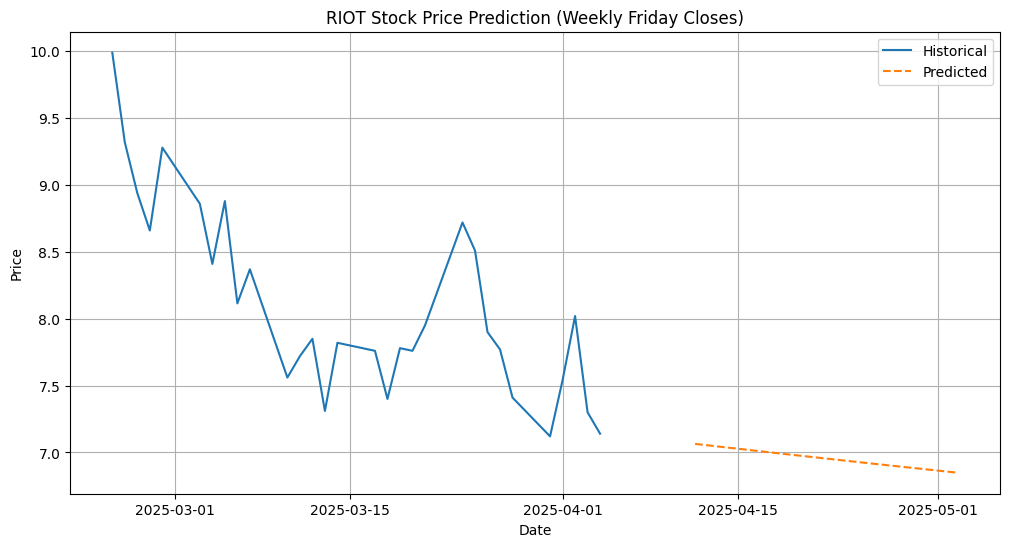


Last Known Price (as of 2025-04-04): $7.14

Predictions for upcoming Fridays:
------------------------------------------------------------
Friday 2025-04-11: $7.06 (Change: -1.07%)
Friday 2025-04-18: $6.99 (Change: -2.10%)
Friday 2025-04-25: $6.92 (Change: -3.11%)
Friday 2025-05-02: $6.85 (Change: -4.09%)
------------------------------------------------------------
Training model for MARA


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/292277404.py:120: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(stock_data['Close'].iloc[-1])
[*********************100%***********************]  1 of 1 completed


Downloaded 751 days of data
Epoch 0: Train Loss = 0.08909, Val Loss = 0.00625
Epoch 5: Train Loss = 0.05059, Val Loss = 0.00530
Epoch 10: Train Loss = 0.04577, Val Loss = 0.00598
Early stopping at epoch 14

Predicting for MARA

Predicting for these Fridays:
2025-04-11
2025-04-18
2025-04-25
2025-05-02

Predictions for upcoming Fridays:
                        Date  Predicted Price  Pct_Change
0 2025-04-11 14:19:43.795382            11.08       -1.92
1 2025-04-18 14:19:43.795382            10.87       -3.78
2 2025-04-25 14:19:43.795382            10.67       -5.59
3 2025-05-02 14:19:43.795382            10.47       -7.35


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/3478244384.py:254: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(stock_data['Close'].iloc[-1])


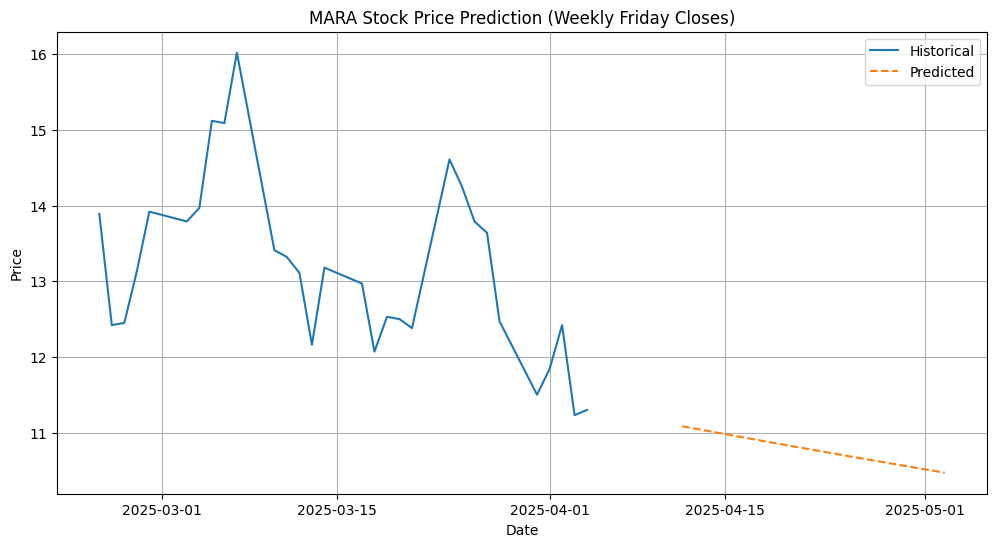


Last Known Price (as of 2025-04-04): $11.30

Predictions for upcoming Fridays:
------------------------------------------------------------
Friday 2025-04-11: $11.08 (Change: -1.92%)
Friday 2025-04-18: $10.87 (Change: -3.78%)
Friday 2025-04-25: $10.67 (Change: -5.59%)
Friday 2025-05-02: $10.47 (Change: -7.35%)
------------------------------------------------------------
Training model for QS


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/292277404.py:120: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(stock_data['Close'].iloc[-1])
[*********************100%***********************]  1 of 1 completed


Downloaded 751 days of data
Epoch 0: Train Loss = 0.07996, Val Loss = 0.02624
Epoch 5: Train Loss = 0.01795, Val Loss = 0.02125
Epoch 10: Train Loss = 0.01457, Val Loss = 0.02045
Early stopping at epoch 12

Predicting for QS

Predicting for these Fridays:
2025-04-11
2025-04-18
2025-04-25
2025-05-02

Predictions for upcoming Fridays:
                        Date  Predicted Price  Pct_Change
0 2025-04-11 14:19:52.806147             3.83       -0.08
1 2025-04-18 14:19:52.806147             3.82       -0.16
2 2025-04-25 14:19:52.806147             3.82       -0.23
3 2025-05-02 14:19:52.806147             3.82       -0.30


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/3478244384.py:254: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(stock_data['Close'].iloc[-1])


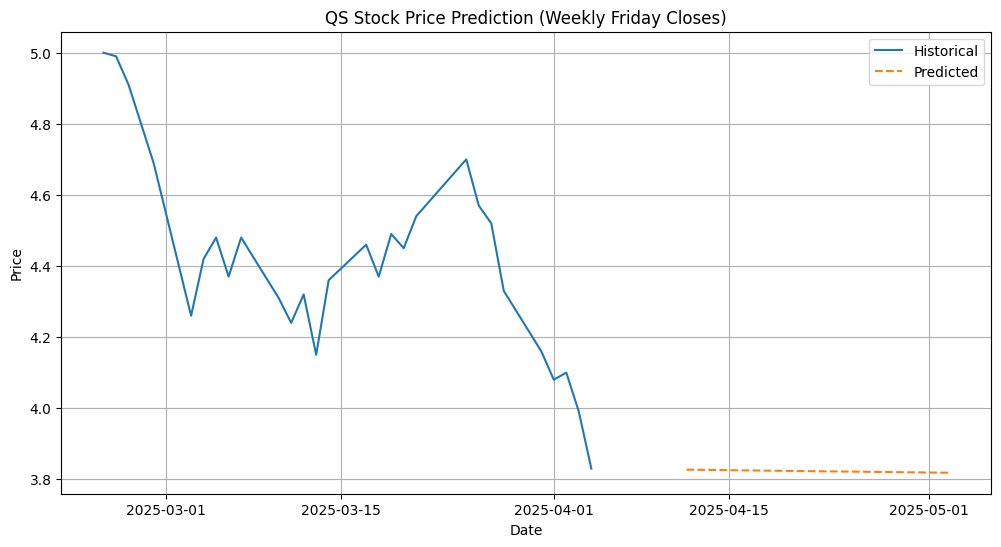


Last Known Price (as of 2025-04-04): $3.83

Predictions for upcoming Fridays:
------------------------------------------------------------
Friday 2025-04-11: $3.83 (Change: -0.08%)
Friday 2025-04-18: $3.82 (Change: -0.16%)
Friday 2025-04-25: $3.82 (Change: -0.23%)
Friday 2025-05-02: $3.82 (Change: -0.30%)
------------------------------------------------------------
Training model for FUBO


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/292277404.py:120: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(stock_data['Close'].iloc[-1])
[*********************100%***********************]  1 of 1 completed


Downloaded 751 days of data
Epoch 0: Train Loss = 0.70547, Val Loss = 0.05808
Epoch 5: Train Loss = 0.62924, Val Loss = 0.05907
Early stopping at epoch 10

Predicting for FUBO

Predicting for these Fridays:
2025-04-11
2025-04-18
2025-04-25
2025-05-02

Predictions for upcoming Fridays:
                        Date  Predicted Price  Pct_Change
0 2025-04-11 14:20:02.014152             2.87        2.51
1 2025-04-18 14:20:02.014152             2.94        5.10
2 2025-04-25 14:20:02.014152             3.02        7.75
3 2025-05-02 14:20:02.014152             3.09       10.45


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/3478244384.py:254: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(stock_data['Close'].iloc[-1])


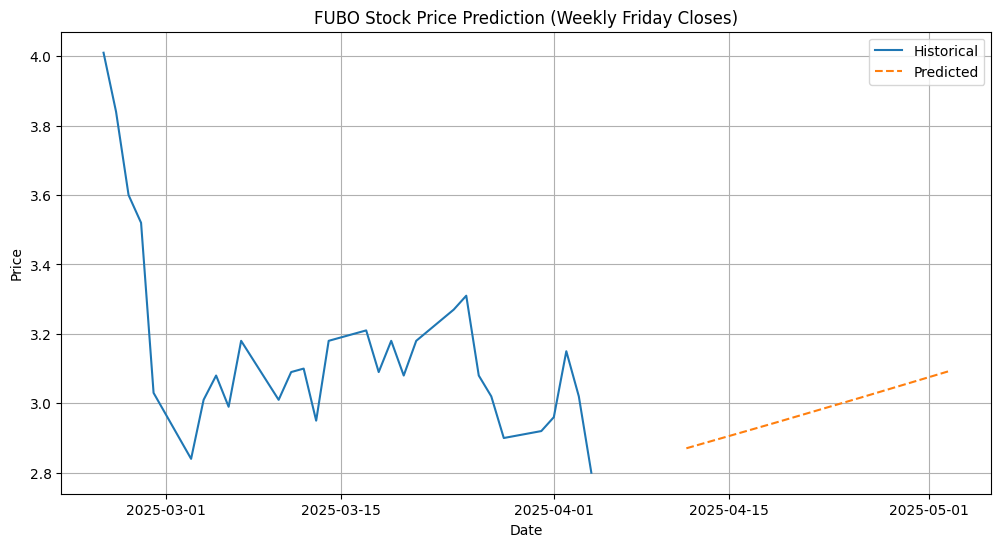


Last Known Price (as of 2025-04-04): $2.80

Predictions for upcoming Fridays:
------------------------------------------------------------
Friday 2025-04-11: $2.87 (Change: +2.51%)
Friday 2025-04-18: $2.94 (Change: +5.10%)
Friday 2025-04-25: $3.02 (Change: +7.75%)
Friday 2025-05-02: $3.09 (Change: +10.45%)
------------------------------------------------------------
Training model for AMC


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/292277404.py:120: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(stock_data['Close'].iloc[-1])
[*********************100%***********************]  1 of 1 completed


Downloaded 751 days of data
Epoch 0: Train Loss = 0.05115, Val Loss = 0.26284
Epoch 5: Train Loss = 0.01153, Val Loss = 0.24829
Epoch 10: Train Loss = 0.00881, Val Loss = 0.24874
Early stopping at epoch 14

Predicting for AMC

Predicting for these Fridays:
2025-04-11
2025-04-18
2025-04-25
2025-05-02

Predictions for upcoming Fridays:
                        Date  Predicted Price  Pct_Change
0 2025-04-11 14:20:12.767169             2.68        1.03
1 2025-04-18 14:20:12.767169             2.71        2.08
2 2025-04-25 14:20:12.767169             2.73        3.14
3 2025-05-02 14:20:12.767169             2.76        4.22


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/3478244384.py:254: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(stock_data['Close'].iloc[-1])


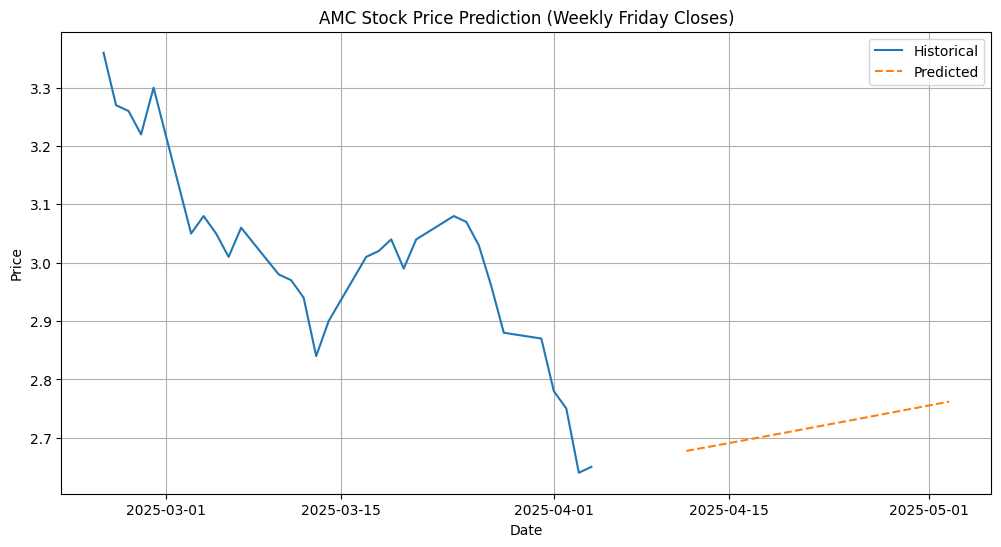


Last Known Price (as of 2025-04-04): $2.65

Predictions for upcoming Fridays:
------------------------------------------------------------
Friday 2025-04-11: $2.68 (Change: +1.03%)
Friday 2025-04-18: $2.71 (Change: +2.08%)
Friday 2025-04-25: $2.73 (Change: +3.14%)
Friday 2025-05-02: $2.76 (Change: +4.22%)
------------------------------------------------------------
Training model for XPEV


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/292277404.py:120: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(stock_data['Close'].iloc[-1])
[*********************100%***********************]  1 of 1 completed


Downloaded 751 days of data
Epoch 0: Train Loss = 0.13387, Val Loss = 0.13601
Epoch 5: Train Loss = 0.09785, Val Loss = 0.13105
Epoch 10: Train Loss = 0.08561, Val Loss = 0.12983
Early stopping at epoch 13

Predicting for XPEV

Predicting for these Fridays:
2025-04-11
2025-04-18
2025-04-25
2025-05-02

Predictions for upcoming Fridays:
                        Date  Predicted Price  Pct_Change
0 2025-04-11 14:20:23.200060            19.83        2.04
1 2025-04-18 14:20:23.200060            20.24        4.17
2 2025-04-25 14:20:23.200060            20.67        6.39
3 2025-05-02 14:20:23.200060            21.12        8.71


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/3478244384.py:254: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(stock_data['Close'].iloc[-1])


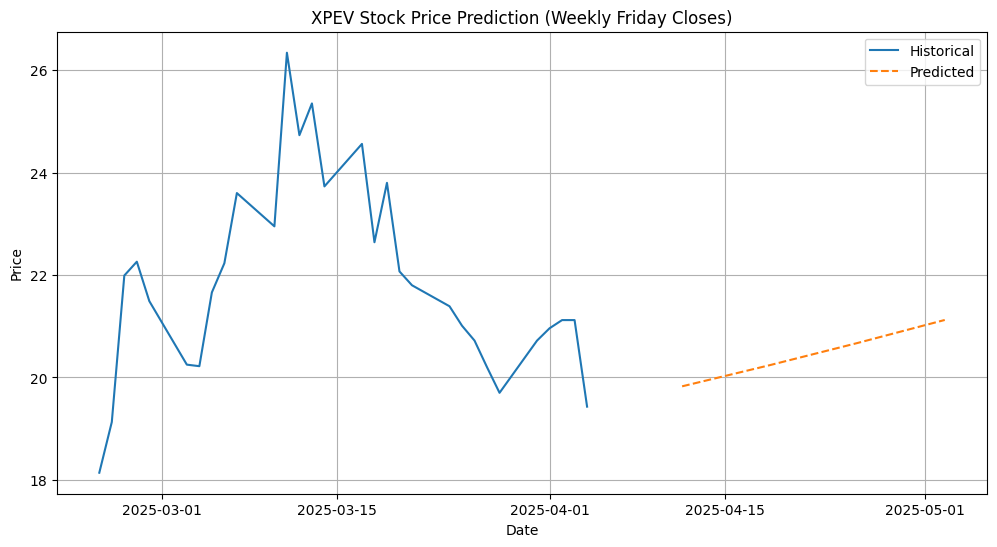


Last Known Price (as of 2025-04-04): $19.43

Predictions for upcoming Fridays:
------------------------------------------------------------
Friday 2025-04-11: $19.83 (Change: +2.04%)
Friday 2025-04-18: $20.24 (Change: +4.17%)
Friday 2025-04-25: $20.67 (Change: +6.39%)
Friday 2025-05-02: $21.12 (Change: +8.71%)
------------------------------------------------------------
Training model for GME


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/292277404.py:120: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(stock_data['Close'].iloc[-1])
[*********************100%***********************]  1 of 1 completed


Downloaded 751 days of data
Epoch 0: Train Loss = 0.05384, Val Loss = 0.62094
Epoch 5: Train Loss = 0.01680, Val Loss = 0.62459
Early stopping at epoch 10

Predicting for GME

Predicting for these Fridays:
2025-04-11
2025-04-18
2025-04-25
2025-05-02

Predictions for upcoming Fridays:
                        Date  Predicted Price  Pct_Change
0 2025-04-11 14:20:31.572333            24.10        2.60
1 2025-04-18 14:20:31.572333            24.72        5.25
2 2025-04-25 14:20:31.572333            25.36        7.95
3 2025-05-02 14:20:31.572333            26.00       10.70


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/3478244384.py:254: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(stock_data['Close'].iloc[-1])


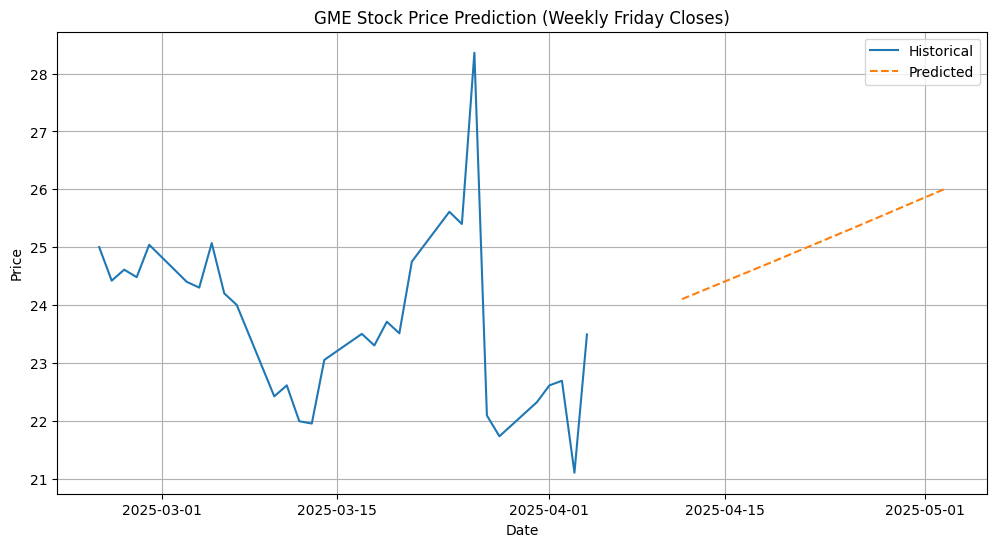


Last Known Price (as of 2025-04-04): $23.49

Predictions for upcoming Fridays:
------------------------------------------------------------
Friday 2025-04-11: $24.10 (Change: +2.60%)
Friday 2025-04-18: $24.72 (Change: +5.25%)
Friday 2025-04-25: $25.36 (Change: +7.95%)
Friday 2025-05-02: $26.00 (Change: +10.70%)
------------------------------------------------------------
Training model for TLRY


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/292277404.py:120: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(stock_data['Close'].iloc[-1])
[*********************100%***********************]  1 of 1 completed


Downloaded 751 days of data
Epoch 0: Train Loss = 0.05189, Val Loss = 0.00765
Epoch 5: Train Loss = 0.00898, Val Loss = 0.00822
Epoch 10: Train Loss = 0.00694, Val Loss = 0.00745
Early stopping at epoch 12

Predicting for TLRY

Predicting for these Fridays:
2025-04-11
2025-04-18
2025-04-25
2025-05-02

Predictions for upcoming Fridays:
                        Date  Predicted Price  Pct_Change
0 2025-04-11 14:20:40.861756             0.61        3.04
1 2025-04-18 14:20:40.861756             0.63        6.17
2 2025-04-25 14:20:40.861756             0.65        9.40
3 2025-05-02 14:20:40.861756             0.67       12.73


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/3478244384.py:254: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(stock_data['Close'].iloc[-1])


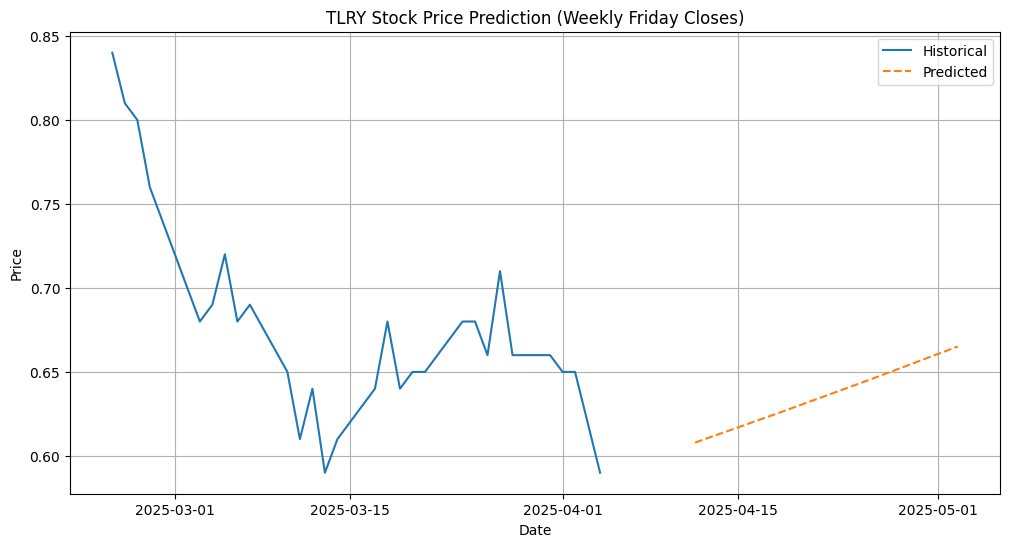


Last Known Price (as of 2025-04-04): $0.59

Predictions for upcoming Fridays:
------------------------------------------------------------
Friday 2025-04-11: $0.61 (Change: +3.04%)
Friday 2025-04-18: $0.63 (Change: +6.17%)
Friday 2025-04-25: $0.65 (Change: +9.40%)
Friday 2025-05-02: $0.67 (Change: +12.73%)
------------------------------------------------------------
Training model for OCGN


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/292277404.py:120: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(stock_data['Close'].iloc[-1])
[*********************100%***********************]  1 of 1 completed


Downloaded 751 days of data
Epoch 0: Train Loss = 0.25303, Val Loss = 0.01411
Epoch 5: Train Loss = 0.23369, Val Loss = 0.01077
Epoch 10: Train Loss = 0.23415, Val Loss = 0.00773
Epoch 15: Train Loss = 0.22327, Val Loss = 0.00770
Epoch 20: Train Loss = 0.22357, Val Loss = 0.00780
Epoch 25: Train Loss = 0.22453, Val Loss = 0.00768
Epoch 30: Train Loss = 0.24306, Val Loss = 0.00774
Early stopping at epoch 31

Predicting for OCGN

Predicting for these Fridays:
2025-04-11
2025-04-18
2025-04-25
2025-05-02

Predictions for upcoming Fridays:
                        Date  Predicted Price  Pct_Change
0 2025-04-11 14:21:02.210160             0.69        4.07
1 2025-04-18 14:21:02.210160             0.72        8.04
2 2025-04-25 14:21:02.210160             0.74       11.88
3 2025-05-02 14:21:02.210160             0.77       15.62


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/3478244384.py:254: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(stock_data['Close'].iloc[-1])


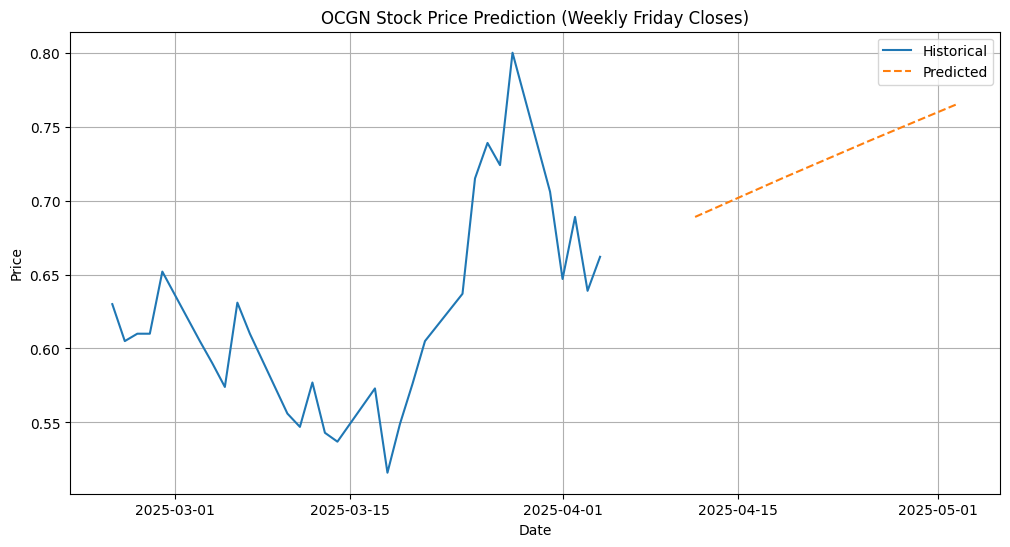


Last Known Price (as of 2025-04-04): $0.66

Predictions for upcoming Fridays:
------------------------------------------------------------
Friday 2025-04-11: $0.69 (Change: +4.07%)
Friday 2025-04-18: $0.72 (Change: +8.04%)
Friday 2025-04-25: $0.74 (Change: +11.88%)
Friday 2025-05-02: $0.77 (Change: +15.62%)
------------------------------------------------------------
Training model for ENPH


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/292277404.py:120: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(stock_data['Close'].iloc[-1])
[*********************100%***********************]  1 of 1 completed


Downloaded 751 days of data
Epoch 0: Train Loss = 0.03981, Val Loss = 0.00499
Epoch 5: Train Loss = 0.00611, Val Loss = 0.00501
Early stopping at epoch 10

Predicting for ENPH

Predicting for these Fridays:
2025-04-11
2025-04-18
2025-04-25
2025-05-02

Predictions for upcoming Fridays:
                        Date  Predicted Price  Pct_Change
0 2025-04-11 14:21:10.457345            56.48       -1.37
1 2025-04-18 14:21:10.457345            55.70       -2.74
2 2025-04-25 14:21:10.457345            54.92       -4.10
3 2025-05-02 14:21:10.457345            54.15       -5.44


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/3478244384.py:254: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(stock_data['Close'].iloc[-1])


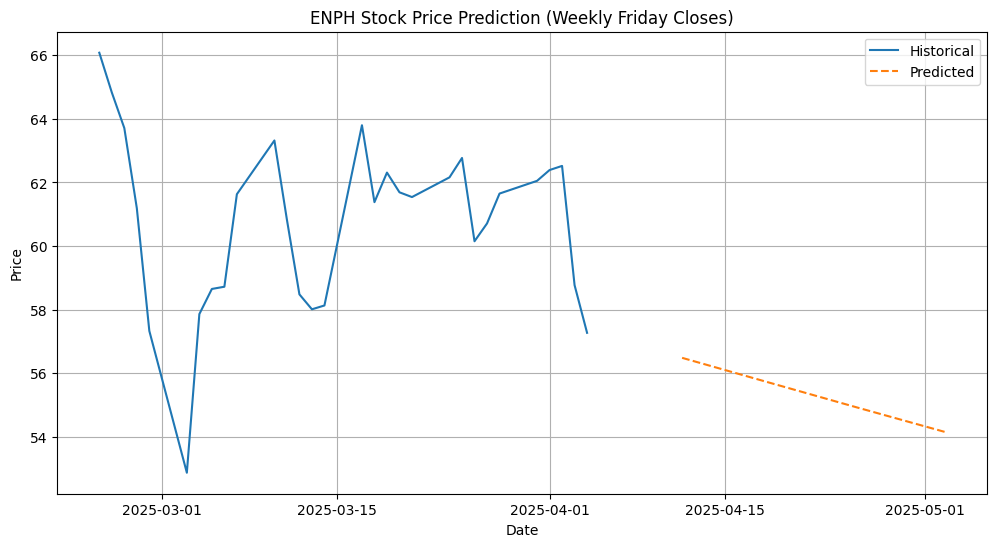


Last Known Price (as of 2025-04-04): $57.27

Predictions for upcoming Fridays:
------------------------------------------------------------
Friday 2025-04-11: $56.48 (Change: -1.37%)
Friday 2025-04-18: $55.70 (Change: -2.74%)
Friday 2025-04-25: $54.92 (Change: -4.10%)
Friday 2025-05-02: $54.15 (Change: -5.44%)
------------------------------------------------------------
Training model for PLTR


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/292277404.py:120: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(stock_data['Close'].iloc[-1])
[*********************100%***********************]  1 of 1 completed


Downloaded 751 days of data
Epoch 0: Train Loss = 0.13974, Val Loss = 0.02777
Epoch 5: Train Loss = 0.08218, Val Loss = 0.00217
Epoch 10: Train Loss = 0.07494, Val Loss = 0.00227
Early stopping at epoch 14

Predicting for PLTR

Predicting for these Fridays:
2025-04-11
2025-04-18
2025-04-25
2025-05-02

Predictions for upcoming Fridays:
                        Date  Predicted Price  Pct_Change
0 2025-04-11 14:21:21.128931            76.46        3.31
1 2025-04-18 14:21:21.128931            78.99        6.73
2 2025-04-25 14:21:21.128931            81.62       10.29
3 2025-05-02 14:21:21.128931            84.34       13.96


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/3478244384.py:254: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(stock_data['Close'].iloc[-1])


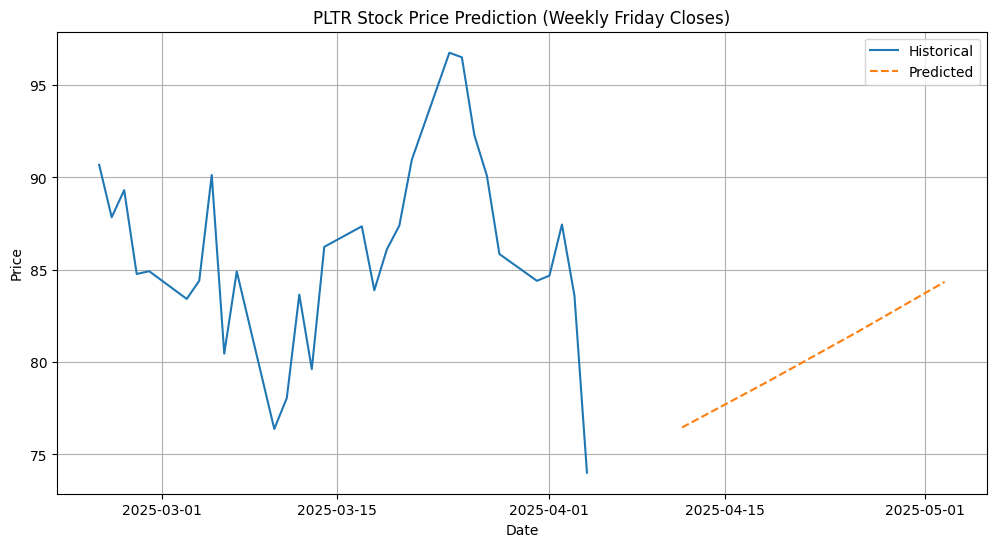


Last Known Price (as of 2025-04-04): $74.01

Predictions for upcoming Fridays:
------------------------------------------------------------
Friday 2025-04-11: $76.46 (Change: +3.31%)
Friday 2025-04-18: $78.99 (Change: +6.73%)
Friday 2025-04-25: $81.62 (Change: +10.29%)
Friday 2025-05-02: $84.34 (Change: +13.96%)
------------------------------------------------------------


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/292277404.py:120: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(stock_data['Close'].iloc[-1])


In [ ]:
def train(ticker):
    # Set date range
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*3)  # 3 years of data
    
    try:
        # Download and prepare data
        print(f"Downloading data for {ticker} from {start_date} to {end_date}")
        stock_data = download_stock_data(ticker, start_date, end_date)
        if stock_data.empty:
            raise ValueError(f"No data downloaded for {ticker}")
        
        print(f"Downloaded {len(stock_data)} days of data")
        
        # Handle missing values first
        stock_data = stock_data.ffill().bfill()
        enhanced_data = add_option_indicators(stock_data, ticker)
        
        # Define available features
        available_features = [
            'Open', 'High', 'Low', 'Close', 'Volume',  # OHLCV
            '1w_return', '2w_return', '1m_return', '20d_vol',  # Momentum
            'RSI', 'MACD', 'MACD_signal', 'MACD_hist',  # Technical
            'BBL', 'BBM', 'BBU',  # Bollinger Bands
            'above_200ma', 'above_50ma'  # Trend
        ]
        
        # Handle missing values
        enhanced_data = enhanced_data.ffill().bfill()
        enhanced_data = enhanced_data.dropna()
        
        if len(enhanced_data) == 0:
            raise ValueError("No valid data after preprocessing")
        
        # Select features and scale
        features = enhanced_data[available_features].values
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        
        # Create sliding windows
        window_size = 20
        X, y = create_sliding_windows(features_scaled, window_size)
        
        if len(X) == 0 or len(y) == 0:
            raise ValueError("No valid sequences created")
        
        # Split data
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Add validation set
        val_size = int(len(X_train) * 0.2)
        X_val = X_train[-val_size:]
        y_val = y_train[-val_size:]
        X_train = X_train[:-val_size]
        y_train = y_train[:-val_size]
        
        # Model parameters
        input_size = len(available_features)
        hidden_size = 128
        num_layers = 2
        output_size = 1
        
        # Initialize model
        model = StockLSTM(input_size, hidden_size, num_layers, output_size).to(device)
        
        # Training parameters
        learning_rate = 0.0001
        num_epochs = 50
        batch_size = 32
        
        # Create data loaders
        train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device), 
                                    torch.FloatTensor(y_train).to(device))
        val_dataset = TensorDataset(torch.FloatTensor(X_val).to(device), 
                                  torch.FloatTensor(y_val).to(device))
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Optimizer with L2 regularization
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        criterion = nn.MSELoss()
        
        # Train with validation
        train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)
        
        return model, features_scaled, window_size, ticker, scaler, stock_data, enhanced_data
        
    except Exception as e:
        print(f"Error in training: {str(e)}")
        return None, None, None, None, None, None, None


# Example usage:
base_tickers = get_high_interest_tickers(
    min_volume=500000,        # 1M daily volume
    min_option_interest=500,  # 1K option interest
    max_stocks=10             # Return top 10
)

# Add any additional tickers you want to analyze
additional_tickers = ["QS", "NIO"]

# Combine and remove duplicates
tickers = list(set(base_tickers + additional_tickers))

print("\nAnalyzing these tickers:", tickers)

# Run the model for each ticker
for ticker in tickers:
    print(f"Training model for {ticker}")
    result = train(ticker)
    if result[0] is not None:
        model, features_scaled, window_size, ticker, scaler, stock_data, enhanced_data = result
        print(f"\nPredicting for {ticker}")
        predictions = predict(model, features_scaled, window_size, ticker, scaler, stock_data, enhanced_data, num_weeks=4)
        
        last_known_price = float(stock_data['Close'].iloc[-1])
        last_date = stock_data.index[-1]
        
        print(f"\nLast Known Price (as of {last_date.strftime('%Y-%m-%d')}): ${last_known_price:.2f}")
        print("\nPredictions for upcoming Fridays:")
        print("-" * 60)
        for i in range(4):
            friday_price = float(predictions['Predicted Price'].iloc[i])
            friday_date = predictions['Date'].iloc[i]
            pct_change = ((friday_price/last_known_price - 1) * 100)
            print(f"Friday {friday_date.strftime('%Y-%m-%d')}: ${friday_price:.2f} (Change: {pct_change:+.2f}%)")
        print("-" * 60)
    else:
        print(f"Skipping prediction for {ticker} due to training failure")